# Prediction of Health Measures Based on Location

**Data Scientist:** Elina Rankova

[IMAGE PLACEHOLDER]



## 1. Business Problem and Understanding

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
GradientBoostingRegressor, VotingRegressor, StackingRegressor

## 2. Data Understanding

In [ ]:
# Load datasets

pl1 = pd.read_csv('Data/PLACES_2017-2018.csv')
pl2 = pd.read_csv('Data/PLACES_2018-2019.csv')
pl3 = pd.read_csv('Data/PLACES_2019-2020.csv')
pl4 = pd.read_csv('Data/PLACES_2020-2021.csv')
sdoh = pd.read_csv('Data/SDOH_2017-2021.csv')

We may want to check on the `StateAbbr` and `StateDesc` since it's showing the country in the preview. We also want to adjust the LocationName to either exclude 'county' or include 'county' to make sure both of the datasets are aligned in nomenclature.

Since the data we are working with is by county, we can eliminate the added specification with the `LocationName` in the SDOH dataset.

We will also have to deal with the differences in the `Year` column since it is an object in the SDOH data and an integer in the PLACES data.

In [ ]:
# Concat all PLACES datasets
pl_all = pd.concat([pl1, pl2, pl3, pl4])
display(pl_all.tail())

sdoh.head()

In [ ]:
# Lowercase all data to ensure consistancy
sdoh = sdoh.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
pl_all = pl_all.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Delete the 'county' specification
sdoh['LocationName'] = sdoh['LocationName'].str.replace('county',"")

In [ ]:
print(sdoh.info())
print(pl_all.info())

We will have to drop `Low_Confidence_Limit` and `High_Confidence_Limit` since the SDOH dataset does not have these columns.

In [ ]:
print(sdoh.isna().sum()/sdoh.shape[0],'\n')
print(pl_all.isna().sum()/pl_all.shape[0])

In [ ]:
# Merge all datasets together
df_all = pd.concat([pl_all, sdoh])

Right away we can tell that there are a few columns that are missing too many values and will need to be dropped.
- `Data_Value_Footnote_Symbol`
- `Data_Value_Footnote`
- `Latitude`
- `MOE`

`Geolocatioin` and `Geolocation` are the same feature when checking the source data websites only the 2020 release has a `Geolocatioin` column while the rest have `Geolocation`. `MeasureID` and `MeasureId` have the same issue it seems.

There are object type columns that will need to be transformed. Since state should be treated as a categorical variable we should adjust this in our dataset.

In addition, we would also want to make `LocationID` an object since this is not an actual continuous variable.

In [ ]:
print(df_all.info(),'\n')

# Drop unneeded columns
df_all.drop(columns=['Data_Value_Footnote_Symbol','Data_Value_Footnote','Latitude',
                     'MOE','Low_Confidence_Limit','High_Confidence_Limit'],inplace=True)

We can drop the misspelled `Geolocatioin` after filling in the nas in `Geolocation`. This concept applies to `MeasureID` and `MeasureId` as well.

In [ ]:
# Fill NaNs in Geolocation and with Geolocatioin
df_all.loc[df_all['Geolocation'].isna(), 'Geolocation'] = df_all.loc[df_all['Geolocation'].isna(), 'Geolocatioin']

# Apply the same method to `MeasureID
df_all.loc[df_all['MeasureID'].isna(), 'MeasureID'] = df_all.loc[df_all['MeasureID'].isna(), 'MeasureId']

# Drop unneeded columns
df_all.drop(columns=['MeasureId','Geolocatioin'],axis=1,inplace=True)

df_all.info()

We can drop nas in any columns we are not already dropping such as `LocationName` and the updated `Geolocation`. `LocationID` refers to the zipcode so we should first see if we can impute with the proper zipcode before droping nas.

In [ ]:
print(df_all.isna().sum()/df_all.shape[0])

df_all.dropna(subset=['LocationName','Geolocation'],inplace=True)

Looks like we were able to fill the nas using the associated `LocationID` with existing `Geolocation` as a unique identifier for the zipcode. 

In [ ]:
# Filter rows with non-null LocationID
loc_df = df_all.loc[df_all['LocationID'].notna(), ['Geolocation', 'LocationID']]

# Create LocationName <> LocationID dictionary
loc_dict = dict(zip(loc_df['Geolocation'], loc_df['LocationID']))

# Fill missing LocationID values based on LocationName from the dictionary
df_all['LocationID'] = df_all['LocationID'].fillna(df_all['Geolocation'].map(loc_dict))

# Drop the rest of the nas in LocationID
df_all.dropna(inplace=True)

# Check the percentage of missing values in df_all after filling missing values
print(df_all.isna().sum() / df_all.shape[0])

In [ ]:
# Convert 'StateAbbr' and 'LocationID' columns to appropriate type
df_all['StateAbbr'] = df_all['StateAbbr'].astype('category')
df_all['LocationID'] = df_all['LocationID'].astype('object')

### Column Exploration

<ins>**Observations**</ins>

- We will likely drop `Year` as it can only provide relevant information for the data we retrieved from the PLACES datasets. Otherwise, we have the same date range as seen in the added SDOH data (2017-2021).
- Looks like we may want to drop the rows with US as the state as it is an error. We can also drop `StateDesc` since it's the same info as `StateAbbr`.
- `DataSource` can be dropped since all of the information is coming from the Behavioral Risk Factor Surveillance System or the 5-year American Community Survey which only contains SDOH data.
- `Data_Value_Unit` can be dropped since all of our data values are in percentages.
- `Data_Value_Type` will be helpful for interpretation of our predictions since it denotes what percentage the `Data_Value` represents. `DataValueTypeID` corresponds to this feature and can be dropped since `Data_Value_Type` is more informative.
- `CategoryID` corresponds to `Category` so we can drop it since `Category is easier to interpret.
- `MeasureId` corresponds the same way to `Measure`. However `Measure` values can be quite lengthy depending on the measure. We also have `Short_Question_Text' corresponding to these features and is more informative than `MeausureId` but shorter than `Measure` so we will keep `Short_Question_Text` and create a reference dictionary before dropping the other columns.

In [ ]:
print(df_all['Year'].value_counts(),'\n')
print(df_all['StateAbbr'].value_counts(),'\n')
print(df_all['DataSource'].value_counts(),'\n')
print(df_all['Data_Value_Unit'].value_counts(),'\n')
print(df_all['Data_Value_Type'].value_counts(),'\n')
print(df_all['CategoryID'].value_counts(),'\n')
print(df_all['MeasureID'].value_counts(),'\n')
print(df_all['DataValueTypeID'].value_counts(),'\n')
print(df_all['Short_Question_Text'].value_counts(),'\n')

In [ ]:
# Create reference dictionary for category and measure
measure_df = df_all[['Measure','Short_Question_Text','MeasureID']]
measure_dict = dict(zip(measure_df['MeasureID'], zip(measure_df['Short_Question_Text'], measure_df['Measure'])))
category_df = df_all[['Category','CategoryID']]
category_dict = dict(zip(category_df['Category'],category_df['CategoryID']))

In [ ]:
# Drop rows with US as state
df_all = df_all.loc[df_all['StateAbbr'] != 'US']

# Drop other relevant columns
df_all.drop(columns=['DataSource','Data_Value_Unit','CategoryID','DataValueTypeID',
                     'StateDesc', 'MeasureID','Year','Measure'],inplace=True)
df_all.columns

Let's quickly check for duplicates since we had to download all of the PLACES datasets separately to accomodate the year range in the SDOH dataset.

In [ ]:
dups = df_all.duplicated()
dups.value_counts()

In [ ]:
# Drop identified duplicates
df_all.drop_duplicates(ignore_index=True, inplace=True)
df_all.info()

In [ ]:
# Save df_all as csv
df_all.to_csv('Data/df_all_clean.csv',index=False)

### Statistical Analysis

Before we move onto defining the target, we should look at the numerical distribution of the `Data_Value` and `TotalPopulation` columns. 

We can see there are some outliers in both columns we should consider visualizing and potentially dropping to get a more accurate representation of our distributions.

In [ ]:
df_all[['Data_Value','TotalPopulation']].describe()

When visualizing these features, we can estimate that any `Data_Value` above ~85 is an outlier. It is harder to determine for `TotalPopulation`. We should look at the values of these more closely.

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
sns.boxplot(df_all['Data_Value'],ax=ax[0])
ax[0].set_title('Data Value Distribution')

sns.boxplot(df_all['TotalPopulation'],ax=ax[1])
ax[1].set_title('Total Population Distribution');

Looking at our z-score distribution there are around 10000 rows with a `TotalPopulation` greater than 3 standard deviations ouside the mean. All of the `Data_Value` is within 3 standard deviations within the mean so we won't drop those values quite yet. 

In [ ]:
# Create subset df and get zscores
df_sub = df_all[['TotalPopulation','Data_Value']]
zscores = zscore(df_sub)

# Identify how many rows we would be dropping
print('Total Population > 3 std outside the mean:',zscores.loc[(zscores['TotalPopulation']<-3)|
      (zscores['TotalPopulation']>3)].shape[0])
print('Data Value > 3 std outside the mean:',zscores.loc[(zscores['Data_Value']<-3)|
      (zscores['Data_Value']>3)].shape[0])

In [ ]:
# Identify rows in df
outlier_rows = ((zscore(df_all['TotalPopulation'])>3)|(zscore(df_all['TotalPopulation'])<-3))

df_norm = df_all.loc[~outlier_rows]

print(df_all.shape)
print(df_norm.shape)

### Defining the Target

Now that our dataframe is aligned with our project goals, we can define our target variable `health_disparity_index`. 

To start, we will create a general index taking the average of all data values for each location and create a feature in the full dataset to represent this disparity index. For now, we will ignore Data_Value_Type, Measure, and Category.

In [ ]:
# Isolate Geolocation & Data_Value without specifying or paying attention to Data_Value_type 
avg_idx = df_all[['Geolocation','Data_Value']]

# Aggregate average Data_Value per Geolocation
avg_idx = avg_idx.groupby(by=['Geolocation']).mean().reset_index()
avg_idx_dict = dict(zip(avg_idx['Geolocation'], avg_idx['Data_Value']))

# Copy dataframe
df_avg_idx = df_all.copy()

# Create Avg_Idx column
df_avg_idx['Avg_Idx'] = df_avg_idx['Geolocation'].map(avg_idx_dict)

Comparing random samples of `Avg_Idx` vs `Data_Value` shows us that there is a lot more variablity in the `Data_Value` before aggregation of all of the data value types. 

There is slighly less variabily in `Avg_Idx` when we plot by `Geolocation` but we should still test different approaches when defining our disparity index to see if we can get an even better representation.

This may mean that a direct mean of all the data value types is not a good reprentation of the disparity index.

In [ ]:
# Helper plotting function

def idx_plot(data,y1,y2,y1_name,y2_name):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

    # Visualize by State
    # Plot by y2
    sns.barplot(data=data, hue='StateAbbr', y=y1.sample(n=1000), 
                palette='Set2', ax=ax[0,0],legend=False)
    ax[0,0].set_title(f'{y1_name} by State')
    ax[0,0].set_xlabel('State')
    
    # Plot by y1
    sns.barplot(data=data, hue='StateAbbr', y=y2.sample(n=1000), 
                palette='Set2', ax=ax[0,1],legend=False)
    ax[0,1].set_title(f'{y2_name} by State')
    ax[0,1].set_xlabel('State') 
    
    # Visualize by Geolocation
    # Plot by y1
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y1, ax=ax[1, 0])
    ax[1, 0].set_title(f'{y1_name} by Geolocation')
    ax[1, 0].set_xlabel('Geolocation')

    ax[1,0].set_xticks([])
    
    # Plot by y2
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y2, ax=ax[1, 1])
    ax[1, 1].set_title(f'{y2_name} by Geolocation')
    ax[1, 1].set_xlabel('Geolocation')

    ax[1,1].set_xticks([])

    plt.tight_layout() 
    plt.show();

idx_plot(df_avg_idx,df_avg_idx['Avg_Idx'],df_avg_idx['Data_Value'],'Avg Idx','Data Value')

Let's try to add a population weight to our `Avg_Idx` based on the total impacted population for each geolocation.

In [48]:
# Isolate Geolocation & TotalPopulation
tot_pop = df_all[['Geolocation','TotalPopulation']]

# Aggregate TotalPopulation per Geolocation
tot_pop = tot_pop.groupby(by=['Geolocation']).sum().reset_index()
tot_pop_dict = dict(zip(tot_pop['Geolocation'], tot_pop['TotalPopulation']))

# Copy dataframe
df_pw_idx = df_avg_idx.copy()

# Create Tot_Pop column
df_pw_idx['Tot_Pop'] = df_pw_idx['Geolocation'].map(tot_pop_dict)

# Create weighed index column
df_pw_idx['Weighed_Idx'] = df_pw_idx['Avg_Idx']*(df_pw_idx['TotalPopulation']/df_pw_idx['Tot_Pop'])

df_pw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808694 entries, 0 to 808693
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            808694 non-null  category
 1   LocationName         808694 non-null  object  
 2   Category             808694 non-null  object  
 3   Data_Value_Type      808694 non-null  object  
 4   Data_Value           808694 non-null  float64 
 5   TotalPopulation      808694 non-null  int64   
 6   Short_Question_Text  808694 non-null  object  
 7   LocationID           808694 non-null  object  
 8   Geolocation          808694 non-null  object  
 9   Avg_Idx              808694 non-null  float64 
 10  Tot_Pop              808694 non-null  int64   
 11  Weighed_Idx          808694 non-null  float64 
dtypes: category(1), float64(3), int64(2), object(6)
memory usage: 68.6+ MB


This gives us slightly more variation among the state aggregation but does the opposite for geolocation and since we are primarily focusing on geolocation as our unique location identifier, this approach takes us away from our goal.

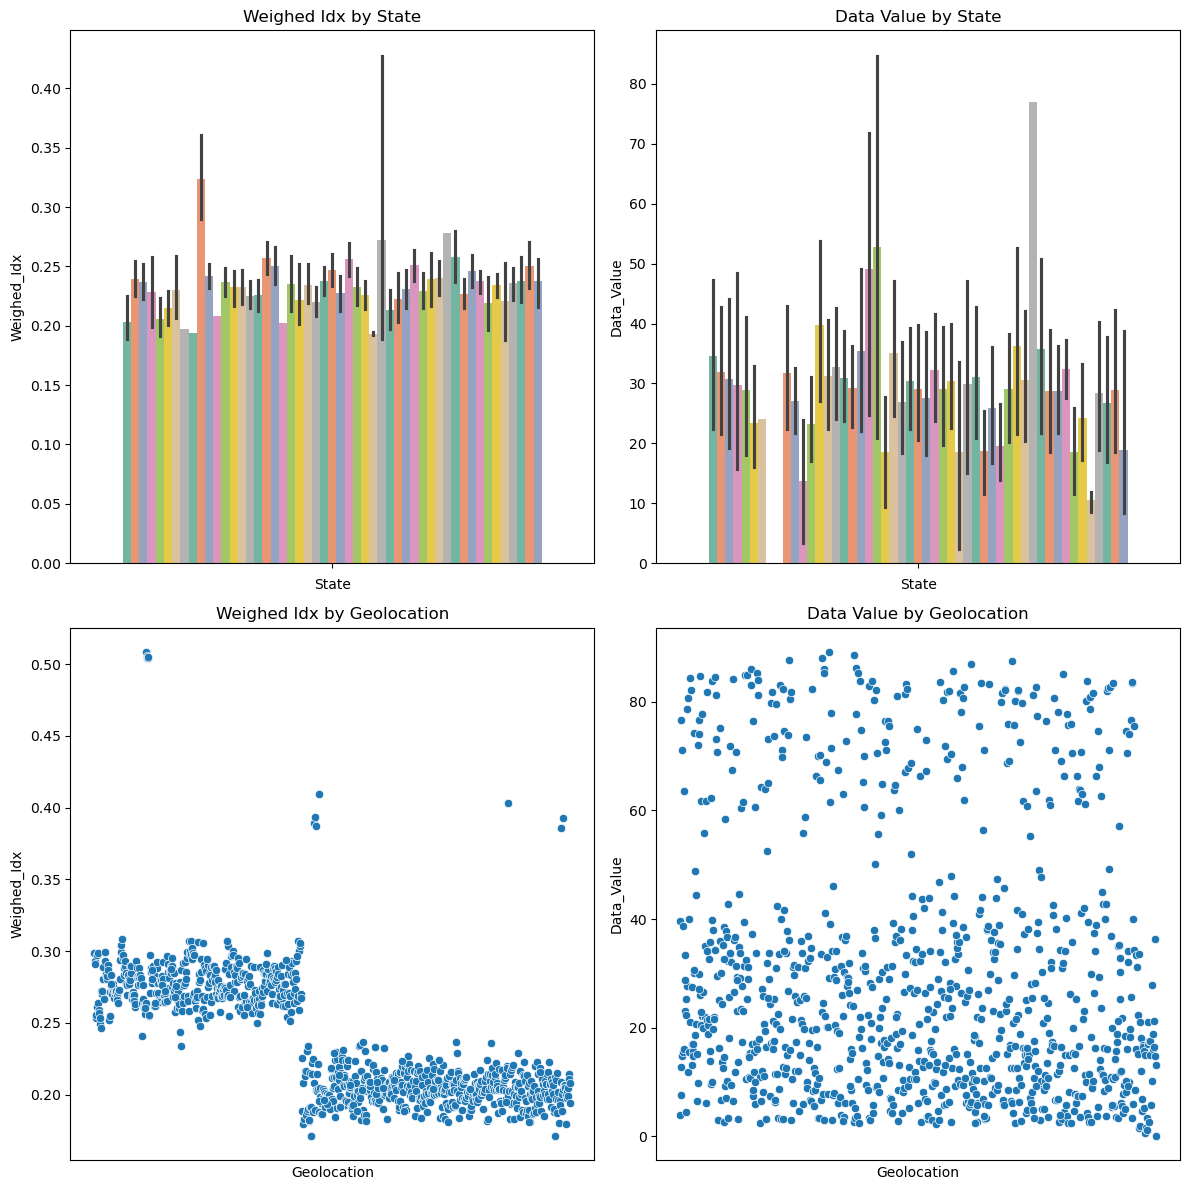

In [26]:
idx_plot(df_pw_idx,df_pw_idx['Weighed_Idx'],df_pw_idx['Data_Value'],'Weighed Idx','Data Value')

## 3. Data Preparation

Since our dataset is so large we will train our model on a smaller training set to save computational power and time.

In [49]:
# Define X, y, and split data

X = df_pw_idx.drop(columns=['Weighed_Idx'])
y = df_pw_idx['Weighed_Idx']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

# Split data into mini-batches
X_batch = np.array_split(X_train.values,20)
y_batch = np.array_split(y_train.values,20)

# Initialize StratifiedShuffleSplit
strat_splitter = StratifiedShuffleSplit(n_splits=1,train_size=.1)

# Generate indices for the stratified sample
for train_index, _ in strat_splitter.split(X_train, y_train):
    X_sampled = X.iloc[train_index]
    y_sampled = y.iloc[train_index]

X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_sampled,y_sampled)

In [50]:
# Define num and cat subpipes
subpipe_num = Pipeline(steps=[('ss',StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Initiate ColumnTranformer
CT = ColumnTransformer(transformers=[('subpipe_num',subpipe_num,[4,5,10]),
                                    ('subpipe_cat',subpipe_cat,[0,1,2,3,6,7,8])],
                      remainder='passthrough')

# Initial Pipeline
init_pipe = Pipeline(steps=[('ct',CT),
                           ('model',LinearRegression())])

In [51]:
init_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5, 10]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7, 8])])),
                ('model', LinearRegression())])

In [37]:
# Baseline Metrics
print('Train RSME:', root_mean_squared_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test RSME:', root_mean_squared_error(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train R-Squared:', r2_score(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test R-Squared:', r2_score(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train MAE:', mean_absolute_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test MAE:', mean_absolute_error(y_samp_test,init_pipe.predict(X_samp_test)))

Train RSME: 4.331070733090092e-06
Test RSME: 0.12261400343919678
Train R-Squared: 0.9999999999957271
Test R-Squared: 0.9965375381434817
Train MAE: 2.3524406682406957e-06
Test MAE: 0.00580851745518312


## Linear Regression Model

Let's see if we can address the overfitting we are seeing in our baseline metrics.

### Lasso

In [53]:
# Replace in pipeline

lasso_pipe = init_pipe.set_params(model=Lasso(max_iter=1000))
lasso_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5, 10]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7, 8])])),
                ('model', Lasso())])

In [57]:
# Define your parameter grid
params_lasso = {
    'model__alpha':[.0001,.001,.01,1,10,100,1000],
    'model__selection': ['cyclic','random']
    
}

rcv_lasso=RandomizedSearchCV(lasso_pipe,param_distributions=params_lasso,scoring='neg_root_mean_squared_error',
                 return_train_score=True,cv=5,n_iter=4,verbose=3)

rcv_lasso.fit(X_samp_train,y_samp_train)
rcv_lasso.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__alpha=10, model__selection=cyclic;, score=(train=-0.041, test=-0.042) total time=   6.0s
[CV 2/5] END model__alpha=10, model__selection=cyclic;, score=(train=-0.041, test=-0.042) total time=   4.1s
[CV 3/5] END model__alpha=10, model__selection=cyclic;, score=(train=-0.042, test=-0.041) total time=   4.3s
[CV 4/5] END model__alpha=10, model__selection=cyclic;, score=(train=-0.041, test=-0.042) total time=   4.6s
[CV 5/5] END model__alpha=10, model__selection=cyclic;, score=(train=-0.042, test=-0.041) total time=   4.6s
[CV 1/5] END model__alpha=100, model__selection=cyclic;, score=(train=-0.041, test=-0.042) total time=   4.3s
[CV 2/5] END model__alpha=100, model__selection=cyclic;, score=(train=-0.041, test=-0.042) total time=   4.4s
[CV 3/5] END model__alpha=100, model__selection=cyclic;, score=(train=-0.042, test=-0.041) total time=   4.2s
[CV 4/5] END model__alpha=100, model__selection=cyclic;, score=(t

{'model__selection': 'random', 'model__alpha': 0.001}

In [55]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,X,y,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': -np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score':-np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, lasso_best = rcv_metrics(rcv_lasso,'Lasso',X_samp_train,y_samp_train)
train_scores

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.031158,0.03116


In [56]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,X,y,test_df=None):
    score_dict = {'Model Name':model_name,
                  'Train Score': root_mean_squared_error(y_samp_train,model.predict(X_samp_train)),
                  'Test Score': root_mean_squared_error(y, model.predict(X))}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score')
    return score_df
    

# Predict on the test
test_scores = test_metrics(lasso_best,'Lasso',X_samp_test,y_samp_test)
test_scores

,Model Name,Train Score,Test Score
0,Lasso,0.020857,0.021483
